# Context

Recent studies have shown that breast cancer continues to be the leading cause of death among women over the world. If detected at an early stage, it can be cured in 9 out of 10 cases.

Automated detection and segmentation of cells from images are the crucial and fundamental steps for the measurement of cellular morphology that is crucial for brest cancer diagnosis and prognosis.


In this notebook, you will learn how to train a segmentation as UNet with **monai** - a framwork based Pytorch Stadard for healthcare imaging.

## Monai

MONAI is a pytorch based open source AI framework launched by NVIDIA and King’s College London.
It is integrated with training and modelling workflows in a native PyTorch Standard. t several places.


Install monai

In [ ]:
!pip install monai
!pip install numpy==1.26.4

Check the installation by running the following cell

In [ ]:
import monai
monai.config.print_config()

#  Dataset

To train a model, we need to prepare some ingredients:

1. Dataset
2. Model
3. Loss function
4. Optimizer

# I. Create Dataset

There are two ways to create your dataset:
- with pytorch Dataset
- with monai.data.Dataset.

In this exercise, we will create our dataset using torch.utils.data.Dataset.

## 1. List all files in folder

Download the dataset from https://zenodo.org/record/1175282#.YMn_Qy-FDox

Notice that there are two kind of folder : original cell picture folder and mask folders. Using your file explorer or some code, display one image and the corresponding image

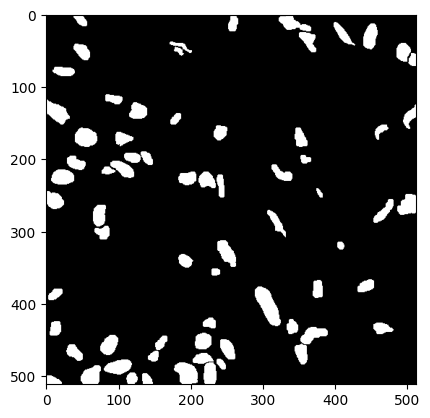

In [143]:
# display image
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

image_path = 'TNBC_NucleiSegmentation/GT_01/01_1.png'
im = Image.open(image_path)
plt.imshow(im, cmap='gray')

## 2. Define a transform
When you load your data, you need to define some transformation. For example, we want to convert image to the format [num_channels, spatial_dim_1, spatial_dim_2] because monai/pytorch use this format. We'll also need to convert the images to PyTorch tensors with transforms.ToTensor()

The following code lets you load image and the labels and define several steps to transform the data.


In [144]:
import torch

from monai.transforms import Compose, LoadImage, EnsureChannelFirst, ToTensor, NormalizeIntensity
from monai.transforms import ScaleIntensity

from monai.data import PILReader

image_trans = Compose(
    [
        LoadImage(image_only=True, reader=PILReader(converter=lambda image: image.convert("RGB"))),
        EnsureChannelFirst(),
        NormalizeIntensity(),
        ToTensor(),
    ])


label_trans = Compose(
    [
        LoadImage(image_only=True),
        EnsureChannelFirst(),
        ScaleIntensity(),
        ToTensor(),
    ])


## 3. Create dataset

The following class CellDataset allows us to create our dataset from "image_files" and "label_files" where:
- "image_files" is a list of image names
- "label_files" is the list of segmentation names respectively.

"im_trans" and "label_trans" are respectively the transforms for the images and their labels.




In [145]:
import torch

class CellDataset(torch.utils.data.Dataset):
    def __init__(self, image_files, label_files, im_trans, label_trans):
        self.image_files = image_files
        self.label_files = label_files
        self.im_trans = im_trans
        self.label_trans = label_trans

    def __len__(self):
        return(len(self.image_files))

    def __getitem__(self, index):
        return self.im_trans(self.image_files[index]), self.label_trans(self.label_files[index])


By using this class, create your training dataset et your test dataset. Remember to check if your dataset is loaded correctly.

In [146]:
from glob import glob
from sklearn.model_selection import train_test_split

image_files = [file for i in range(1, 8) for file in glob(f'TNBC_NucleiSegmentation/Slide_{i:02d}/*.png')]
label_files = [file for i in range(1, 8) for file in glob(f'TNBC_NucleiSegmentation/GT_{i:02d}/*.png')]

image_files_train, image_files_val, label_files_train, label_files_val = train_test_split(
    image_files, label_files, test_size=0.2, random_state=42
)

train_dataset = CellDataset(image_files=image_files_train, label_files=label_files_train, im_trans=image_trans, label_trans=label_trans)
val_dataset = CellDataset(image_files=image_files_val, label_files=label_files_val, im_trans=image_trans, label_trans=label_trans)

## 4. DataLoader

With the your dataset loaded, you have to pass it to a DataLoader. The torch.utils.data.DataLoader takes a dataset and returns batches of images and the corresponding labels. You can set various parameters like the batch size and if the data is shuffled after each epoch.


The following code let you create a data loader for the train dataset, do the same to create a test_loader on the test_dataset. Name it **test_load**


In [176]:
batch_size = 2
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

## 5. Now, time to check your dataloader.

Execute the code following to check if your dataloader works correctly

In [177]:
import monai
im, seg = monai.utils.misc.first(train_loader)
im.shape

torch.Size([2, 3, 512, 512])

# II. Build your segmentation model with monai

Monai already has a UNet model architecture : https://docs.monai.io/en/stable/networks.html#unet

By using the monai.networks.nets module, build a UNet model for segmentation task in 2D. You'll have to choose the following parameters for the model:

1. dimensions (number of spatial dimensions)
2. in_channels (number of input channel)
3. out_channels (number of output channel)
4. channels
5. strides


In [178]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from monai.networks.nets import UNet

# Define the UNet model
model = UNet(
    spatial_dims=2,         # 2D segmentation
    in_channels=3,         # Number of input channels (e.g., grayscale image)
    out_channels=1,        # Number of output channels (e.g., binary segmentation)
    channels=(16,32,64),  # Number of channels in each layer
    strides=(2, 2,),   # Strides for each layer
    num_res_units=2,              # Adding residual units for deeper learning
    norm='batch',                 # Use batch normalization
    dropout=0.2,
)
model = model.to(device)

# III. Define your loss function and optimizer

For a segmentation prob, we usually use DiceLoss.
Using monai.losses.DiceLoss, define your loss function and store it in the variable named **loss_function**. The option sigmoid = True should be used.




In [179]:
from monai.losses import DiceLoss
loss_function = DiceLoss(sigmoid=True)

With torch.optim, define an optimizer for your model. Use the Adam optimiser

In [180]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# IV. Trainning the model

This time, we have all ingredients to train a segmentation model: a model, an optimizer, train_loader and a loss function.  

Monai use a standard PyTorch program style for training a deep learning model.


The general process with Monai/Pytorch just for one learning step  as follows:

1. Load input and label of each batch.

2. Zero accumulated gradients with optimizer.zero_grad()

3. Compute the output from the model

4. Calculate the loss

5. Perform backprop with loss.backward()

6. Update the optimizer with optimizer.step()


Complete the following code so that it do the training


In [181]:
from torch.optim.lr_scheduler import LambdaLR
def lr_lambda(epoch):
    if epoch < 5:
        return (float(epoch) / 5)
    else:
        return 1.0
scheduler = LambdaLR(optimizer, lr_lambda)

In [182]:
def train_model(train_loader, val_loader, model, optimizer, loss_function, device, num_epochs=10):
    epoch_loss_values = []
    epoch_val_loss_values = []
    scheduler = LambdaLR(optimizer, lr_lambda)

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        step = 0

        for batch_data in train_loader:
            step += 1
            inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
            optimizer.zero_grad()

            predictions = model(inputs)
            loss = loss_function(predictions, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            epoch_len = len(train_loader.dataset) // train_loader.batch_size

        scheduler.step()
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        if epoch % 5==0:
          print(f"epoch {epoch + 1} average training loss: {epoch_loss:.4f}")

        model.eval()
        val_loss = 0
        val_step = 0
        with torch.no_grad():
            for batch_data in val_loader:
                val_step += 1
                inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
                predictions = model(inputs)
                loss = loss_function(predictions, labels)
                val_loss += loss.item()

        val_loss /= val_step
        epoch_val_loss_values.append(val_loss)
        if epoch %5 == 0:
          print(f"epoch {epoch + 1} average validation loss: {val_loss:.4f}")

    return epoch_loss_values, epoch_val_loss_values

In [183]:
NUM_EPOCHS = 100

In [184]:
epoch_loss, epoch_val_loss = train_model(train_loader, val_loader, model, optimizer, loss_function, device, num_epochs=NUM_EPOCHS)

epoch 1 average training loss: 0.8385
epoch 1 average validation loss: 0.7911
epoch 6 average training loss: 0.7496
epoch 6 average validation loss: 0.6868
epoch 11 average training loss: 0.7137
epoch 11 average validation loss: 0.6529
epoch 16 average training loss: 0.6568
epoch 16 average validation loss: 0.6080
epoch 21 average training loss: 0.5826
epoch 21 average validation loss: 0.5721
epoch 26 average training loss: 0.4748
epoch 26 average validation loss: 0.5001
epoch 31 average training loss: 0.3891
epoch 31 average validation loss: 0.4678
epoch 36 average training loss: 0.3360
epoch 36 average validation loss: 0.4106
epoch 41 average training loss: 0.3047
epoch 41 average validation loss: 0.3457
epoch 46 average training loss: 0.2865
epoch 46 average validation loss: 0.3790
epoch 51 average training loss: 0.2636
epoch 51 average validation loss: 0.3448
epoch 56 average training loss: 0.2542
epoch 56 average validation loss: 0.3620
epoch 61 average training loss: 0.2461
epoch

Display the prediction of your model on several image

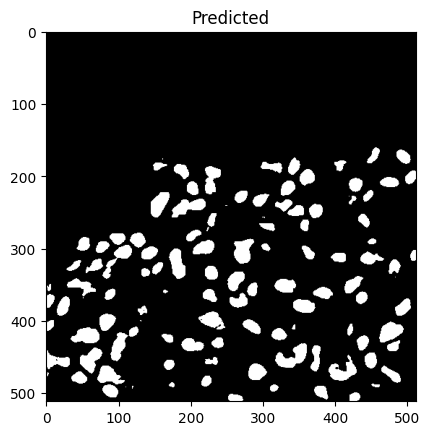

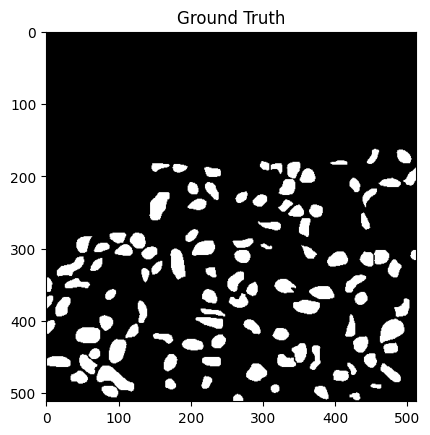

test_loss: 0.2054


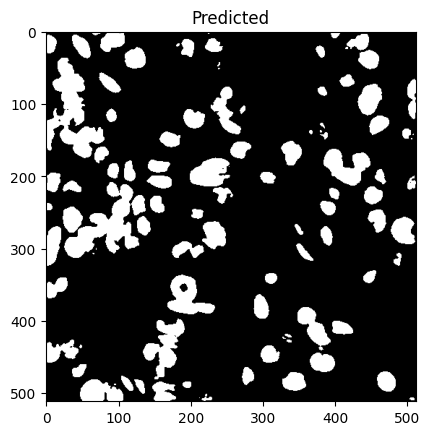

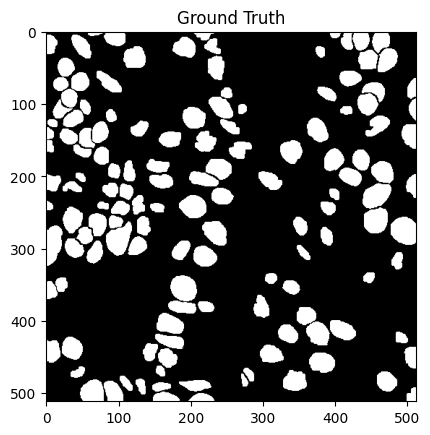

test_loss: 0.2054


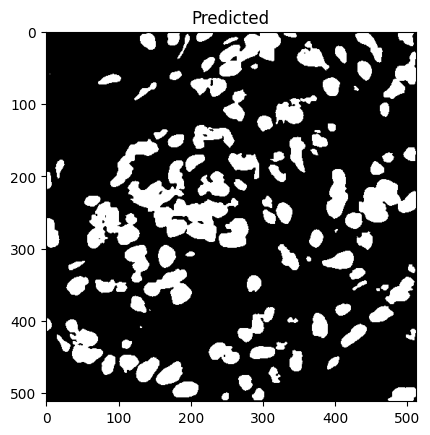

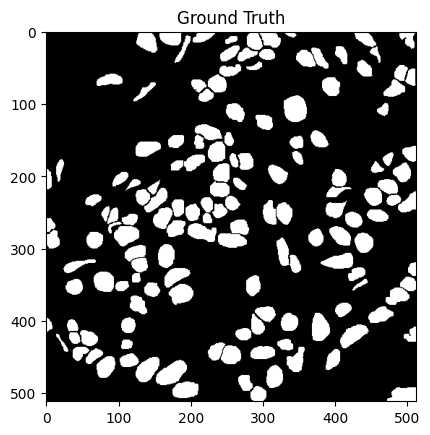

test_loss: 0.2488


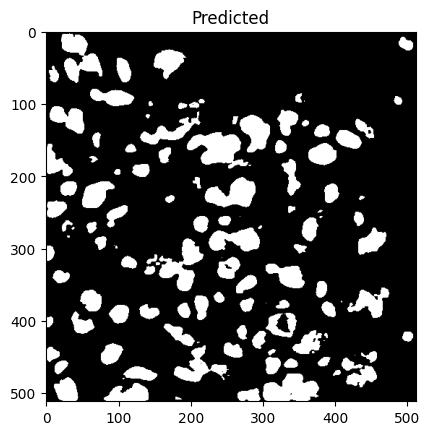

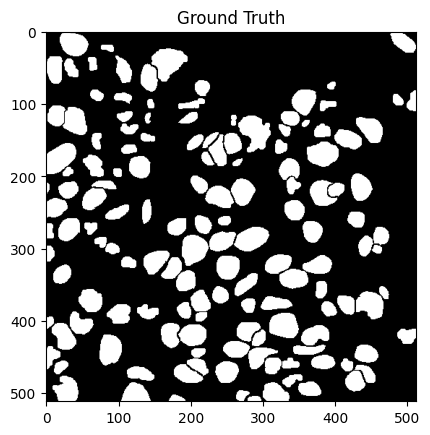

test_loss: 0.2488


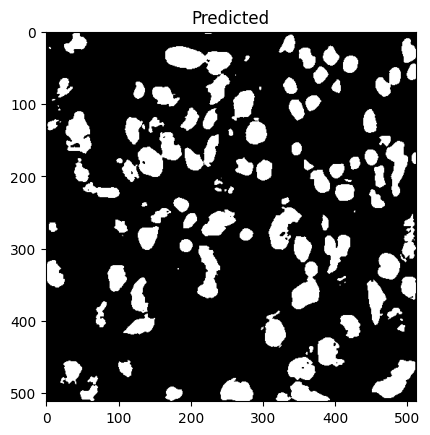

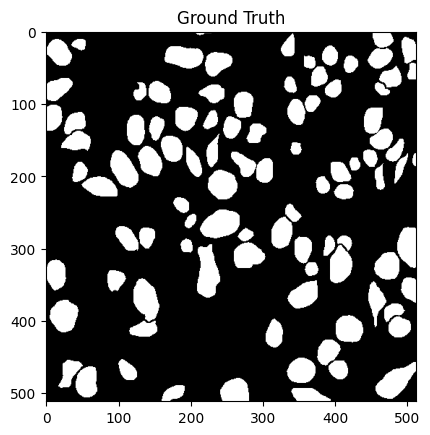

test_loss: 0.2452


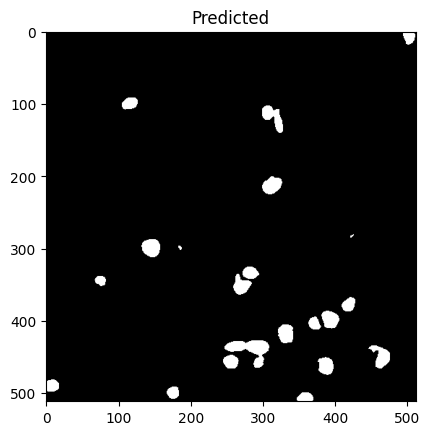

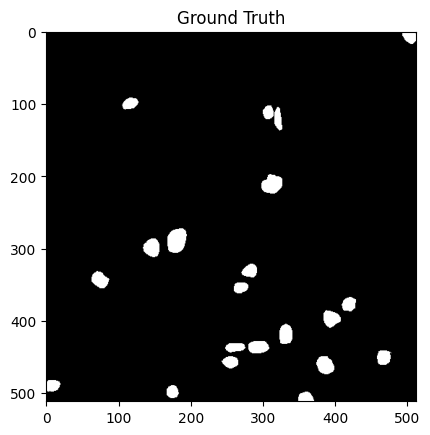

test_loss: 0.2452


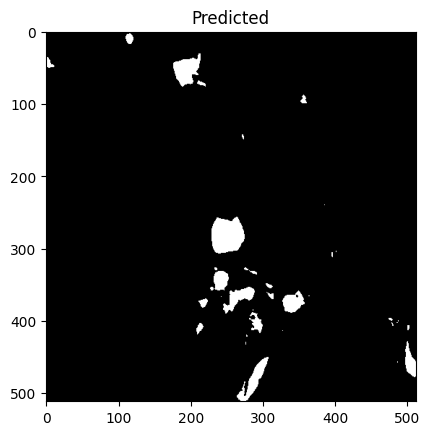

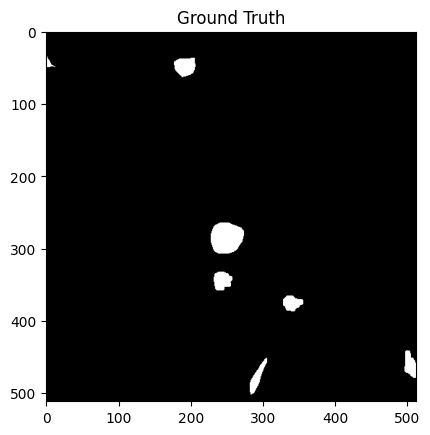

test_loss: 0.3089


In [185]:
model.eval()
for batch_data in val_loader:
    inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
    with torch.no_grad():
        predictions = model(inputs)
        for i in range(len(predictions)):
          plt.imshow(np.where(predictions[i][0].cpu().detach().numpy()>0, 1, 0), cmap='gray', )
          plt.title("Predicted")
          plt.show()
          plt.imshow(labels[i][0].cpu().detach().numpy(), cmap='gray')
          plt.title("Ground Truth")
          plt.show()
          loss = loss_function(predictions, labels)
          print(f"test_loss: {loss.item():.4f}")

Train another architecture (either another Unet architecture or find another segmentation model in the available models of Monai). Compare the results with the first model

In [186]:
from monai.networks.nets import SegResNet

model2 = SegResNet(
    spatial_dims=2,  # 2D segmentation
    in_channels=3,   # Number of input channels
    out_channels=1,  # Number of output channels
    init_filters=32,  # Initial number of filters
    dropout_prob=0.2,  # Dropout probability
)

model2 = model2.to(device)

In [187]:
from monai.losses import DiceLoss
import torch.optim as optim

loss_function = DiceLoss(sigmoid=True)
optimizer2 = optim.Adam(model2.parameters(), lr=1e-3)

In [189]:
epoch_loss2, epoch_val_loss2 = train_model(train_loader, val_loader, model2, optimizer2, loss_function, device, num_epochs=NUM_EPOCHS)

epoch 1 average training loss: 0.8519
epoch 1 average validation loss: 0.8084
epoch 6 average training loss: 0.5766
epoch 6 average validation loss: 0.5420
epoch 11 average training loss: 0.4075
epoch 11 average validation loss: 0.4117
epoch 16 average training loss: 0.3291
epoch 16 average validation loss: 0.3810
epoch 21 average training loss: 0.2635
epoch 21 average validation loss: 0.3007
epoch 26 average training loss: 0.2479
epoch 26 average validation loss: 0.2431
epoch 31 average training loss: 0.2265
epoch 31 average validation loss: 0.2738
epoch 36 average training loss: 0.2089
epoch 36 average validation loss: 0.3160
epoch 41 average training loss: 0.2164
epoch 41 average validation loss: 0.3369
epoch 46 average training loss: 0.1936
epoch 46 average validation loss: 0.2253
epoch 51 average training loss: 0.2032
epoch 51 average validation loss: 0.2084
epoch 56 average training loss: 0.1937
epoch 56 average validation loss: 0.2144
epoch 61 average training loss: 0.1809
epoch

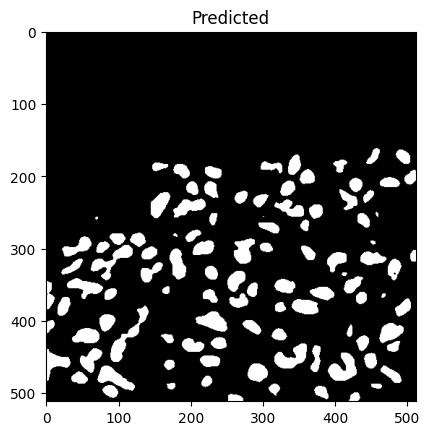

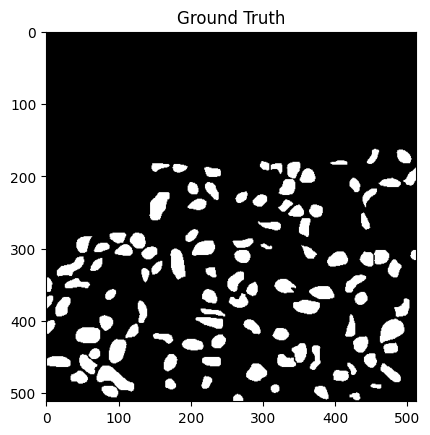

test_loss: 0.1560


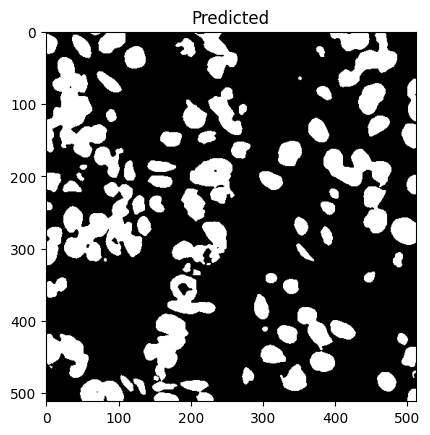

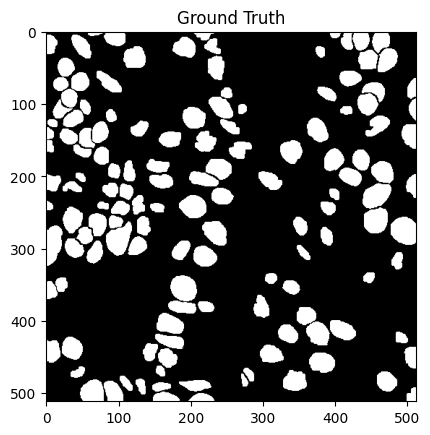

test_loss: 0.1560


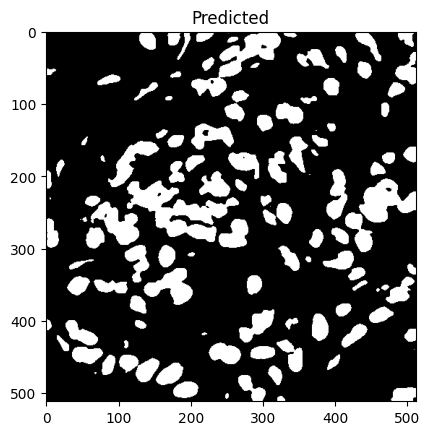

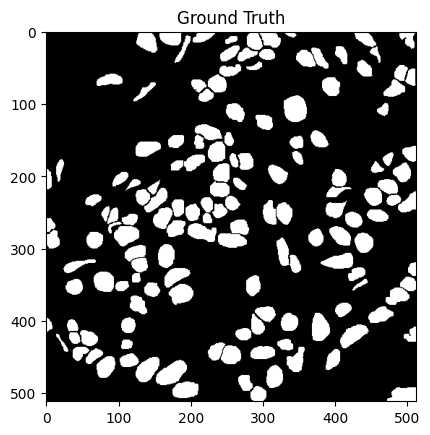

test_loss: 0.2123


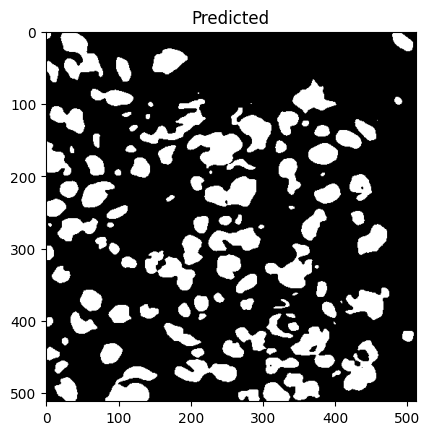

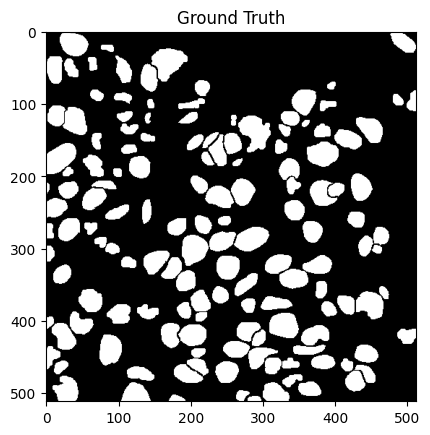

test_loss: 0.2123


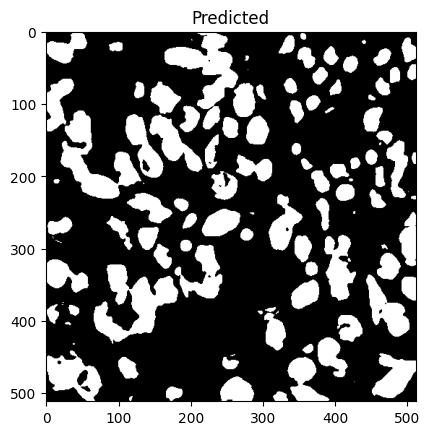

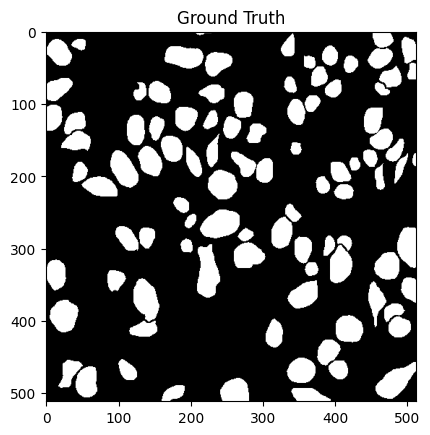

test_loss: 0.2359


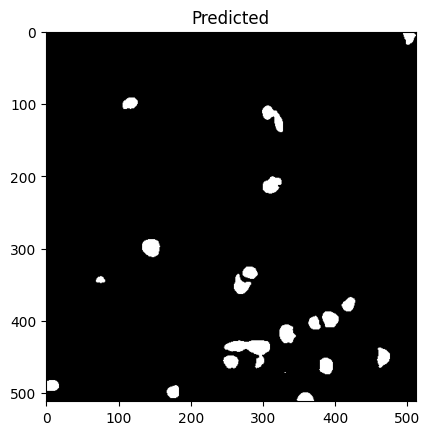

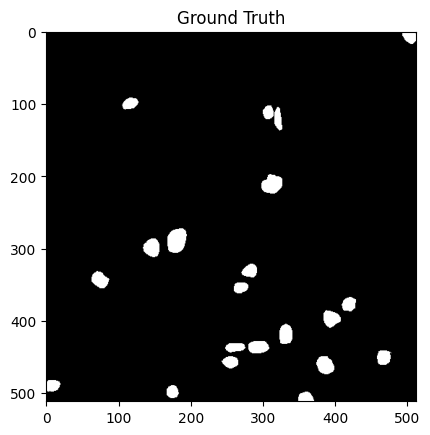

test_loss: 0.2359


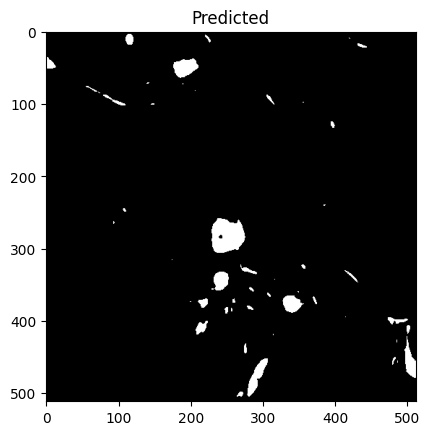

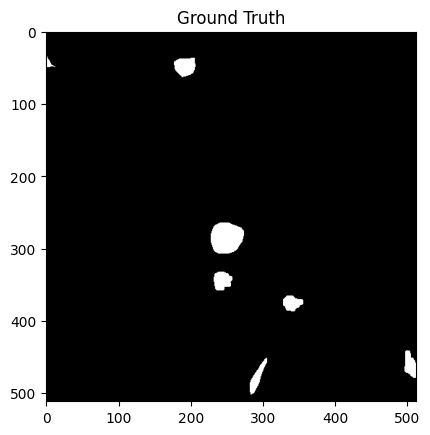

test_loss: 0.2551


In [190]:
model.eval()
for batch_data in val_loader:
    inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
    with torch.no_grad():
        predictions = model2(inputs)
        for i in range(len(predictions)):
          plt.imshow(np.where(predictions[i][0].cpu().detach().numpy()>0, 1, 0), cmap='gray', )
          plt.title("Predicted")
          plt.show()
          plt.imshow(labels[i][0].cpu().detach().numpy(), cmap='gray')
          plt.title("Ground Truth")
          plt.show()
          loss = loss_function(predictions, labels)
          print(f"test_loss: {loss.item():.4f}")

In [191]:
from monai.metrics import compute_iou

def evaluate_model(model, data_loader, device):
    iou_scores = []
    model.eval()
    with torch.no_grad():
        for batch_data in data_loader:
            inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
            predictions = model(inputs)

            iou = compute_iou(predictions, labels, include_background=True)
            iou_scores.extend(iou.cpu().numpy())

    avg_iou = np.mean(iou_scores)
    return avg_iou

unet_dice = evaluate_model(model, val_loader, device)
print(f"UNet IOU Score: {unet_dice:.4f}")

segresnet_dice = evaluate_model(model2, val_loader, device)
print(f"SegResNet IOU Score: {segresnet_dice:.4f}")

UNet IOU Score: -0.2015
SegResNet IOU Score: -0.1529


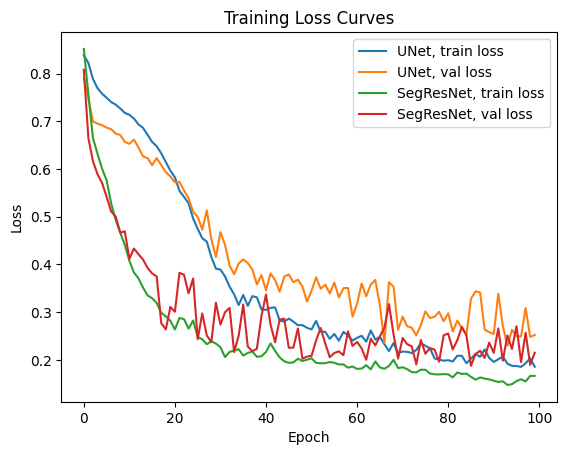

In [192]:
import matplotlib.pyplot as plt

plt.plot(epoch_loss, label="UNet, train loss")
plt.plot(epoch_val_loss, label="UNet, val loss")

plt.plot(epoch_loss2, label="SegResNet, train loss")
plt.plot(epoch_val_loss2, label="SegResNet, val loss")

plt.title("Training Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

Although both models achieved low Intersection over Union (IOU) scores (<0), SegResNet outperformed UNet with the same number of training epochs. SegResNet also demonstrated faster convergence